# Exporing CORD-19 References

This notebooks explores how much information we can obtain from the citation references of the papers in the COVID-19 Open Research Dataset Challenge.

Here we are trying to:

- Load the dataset.
    - How many papers can we parse?
- How to extract the references?
- How many references are also in the CORD-19 dataset?
- How many are out?

Remember to install requirements by running:

```bash
$ pip install -r requirements.txt
```

In [ ]:
import pandas as pd
from fastprogress.fastprogress import progress_bar

from pathlib import Path

import json
import random
import os

/Users/lmarti/.pyenv/versions/3.8.2/envs/risotto/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Loading the CORD-19 dataset

In [ ]:
cord19_dataset_folder = "./datasets/CORD-19-research-challenge"

In [ ]:
if Path(cord19_dataset_folder).exists():
    print('Good to go')
else:
    print(f'{data_root} does not exist! Download it using 00_download.ipynb.')

Good to go


Loading `metadata.csv` file as a pandas `DataFrame`.

In [ ]:
metadata_df = pd.read_csv(f"{cord19_dataset_folder}/metadata.csv", index_col="cord_uid")

How metadata looks like?

In [ ]:
file_in_metadata_count = len(metadata_df)

In [ ]:
f'Total records loaded: {file_in_metadata_count}'

'Total records loaded: 57366'

In [ ]:
metadata_df.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_pdf_parse',
       'has_pmc_xml_parse', 'full_text_file', 'url'],
      dtype='object')

In [ ]:
metadata_df.head(3)

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
cord_uid,,,,,,,,,,,,,,,,,
zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...


Each paper is represented by a unique id called `cord_uid`.

Meaning of columns:

- `sha`: PDF file hash
- `source_x`: source repository, e.g. Biorxiv, Elsevier, etc.
- `title`: paper title
- `doi`, `pmcid`, `pubmed_id`, `Microsoft Academic Paper ID`, `WHO #Covidence`: other document ids
- `license`: usage license
- `abstract`:plain text abstract
- `publish_time`: publish date
- `journal`: academic journal of publication, if applicable
- `authors`: authors in plain text
- `has_pdf_parse`: if PDF parsing is available
- `has_pmc_xml_parse`: if PubMed XML is available
- `full_text_file`: pointer to the source file in the dataset
- `url`: URL to paper online source

A continuación se revisará la estructura de carpetas y archivos del conjunto de datos.

In [ ]:
def _sample_json_file(path):
    for _, _, file_names in os.walk(path):
        sample_file_name = random.choice(file_names)
        file_path = os.path.join(path, sample_file_name)
        with open(file_path) as file:
            contents = json.load(file)
        return list(contents.keys())

In [ ]:
def walk_dataset():
    cum_sum = 0
    for root, folders, files in os.walk(cord19_dataset_folder):
        num_folders = len(folders)
        num_files = len(files)
        if "json" in root and num_folders == 0 and num_files > 0:
            cum_sum += num_files
            print(f"{root}: {num_files} files")
    return cum_sum

In [ ]:
source_file_count = walk_dataset()

./datasets/CORD-19-research-challenge/custom_license/custom_license/pmc_json: 10615 files
./datasets/CORD-19-research-challenge/custom_license/custom_license/pdf_json: 31376 files
./datasets/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pmc_json: 2258 files
./datasets/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json: 2518 files
./datasets/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json: 2278 files
./datasets/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pmc_json: 9390 files
./datasets/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json: 9769 files


In [ ]:
print(f'Files in metadata: {file_in_metadata_count}, source files: {source_file_count}')

Files in metadata: 57366, source files: 68204


In [ ]:
print(f'We have {source_file_count-file_in_metadata_count} files without metadata.')

We have 10838 files without metadata.


Se observan 59.311 archivos, lo que arroja una diferencia de 8.233 respecto a la cantidad de registros en el CSV de metadatos.
Probablemente, existen registros en el CSV de metadatos que tienen más de un archivo.

De acuerdo a la información encontrada en la comunidad de Kaggle, existen al menos dos procedimientos recomendados para cargar los datos.

```python
# Primer procedimiento
for row in metadata_file:
    pmc_id = row["pmc_id"]
    if exists pmc_id file in pmc_jsons subfolders:
        return pmc_id file
    # Si pmc_id es nulo o no existe archivo
    sha = row["sha"]
    if exists sha file in pdf_jsons subfolders:
        return sha file

# Segundo procedimiento
for pdf file in pdf files:
    if pdf file sha not in metadata_file shas:
        continue
    else:
        row = metadata_file row with matching pdf file sha
        pmc_id = row["pmc_id"]
        if exists pmc_id file in pmc_jsons subfolders:
            return pmc_id file
        return pdf file
```

In [ ]:
# 1. Construir diccionarios de PMC files, JSON files
# 2. Iterate metadata file

def get_id_paths_dicts(cls):
    """
    Esta función construye los diccionarios cuyas llaves son identificadores
    de alguna clase de papers (PDF o PMC) y cuyos valores son los paths hacia
    los archivos asociados.
    """
    all_files = {}
    for root, folders, files in os.walk(cord19_dataset_folder):
        num_folders = len(folders)
        num_files = len(files)
        if cls in root and num_folders == 0 and num_files > 0:
            for file_name in files:
                _id = file_name.split(".")[0]
                all_files[_id] = os.path.join(root, file_name)
    return all_files

In [ ]:
pdf_dict = get_id_paths_dicts("pdf")
pmc_dict = get_id_paths_dicts("pmc")
len(pdf_dict), len(pmc_dict)

(45941, 22263)

Se observa la existencia de:

- 40.144 archivos PDF con sus respectivos JSONs
- 19.167 archivos PMC con sus respectivos JSONs

En base a la información anterior, se seguirá el primer procedimiento para cargar los papers.

In [ ]:
class BasePaper:
    def __init__(self, metadata_row, file_path):
        self._metadata_row = metadata_row
        self._file_path = file_path
        self._file_contents = self._load_json_contents(file_path)
        
        self._referenced_by = []
        self._references = []
    
    def __getstate__(self):
        """
        Avoid RecursionErrors by not pickling references.
        """
        state = self.__dict__.copy()
        del state["_referenced_by"]
        del state["_references"]
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)
        self._referenced_by = []
        self._references = []
        
    @staticmethod
    def _load_json_contents(path):
        with open(path) as file:
            contents = json.load(file)
        return contents

    @property
    def title(self):
        return self._metadata_row["title"]
        
    @property
    def authors(self):
        return self._metadata_row["authors"]
        
    @property
    def publish_time(self):
        return self._metadata_row["publish_time"]
        
    @property
    def abstract(self):
        return self._metadata_row["abstract"]
        
    @property
    def bib_entries(self):
        return self._file_contents["bib_entries"]
    
    def register_reference(self, reference):
        self._references.append(reference)
        reference.register_referenced(self)
    
    def register_referenced(self, referenced):
        self._referenced_by.append(referenced)

(38882, 0)

In [ ]:
class PDFPaper(BasePaper):
    pass

In [ ]:
class PMCPaper(BasePaper):
    pass

In [ ]:
def load_papers(metadata_df):
    papers = []
    not_found = []
    for idx, row in progress_bar(metadata_df.iterrows(), total=len(metadata_df)):
        pmc_id = row["pmcid"]
        shas = row["sha"]
        paper = None
        
        if pmc_id in pmc_dict:
            pmc_path = pmc_dict[pmc_id]
            paper = PMCPaper(row, pmc_path)
            
        if paper is None and pd.notna(shas):
            shas_splitted = shas.split("; ")
            for sha in shas_splitted:
                if sha in pdf_dict:
                    pdf_path = pdf_dict[sha]
                    paper = PDFPaper(row, pdf_path)
                    break
        
        if paper is None and (row["has_pdf_parse"] or row["has_pmc_xml_parse"]):
            not_found.append(idx)
        if paper is not None:
            papers.append(paper)
            
    return papers, not_found

In [ ]:
papers, not_found = load_papers(metadata_df)

In [ ]:
print(f'{len(papers)} papers found, {len(not_found)} not found.')

In [ ]:
mask_1 = metadata_df["has_pdf_parse"]
mask_2 = metadata_df["has_pmc_xml_parse"]
print(f'There are {(mask_1 | mask_2).sum()} files with either parsed PDF or PMC XML.')

Somos capaces de identificar los archivos JSONs de 38.882 registros del archivo de metadatos.
Es consistente con que solo 38.882 registros del archivo de metadatos tiene parseado PDF o PMC.

In [ ]:
paper = papers
print('Title:', paper.title)
print('Authors:', paper.authors)
print(paper.abstract)

# Match entre referencias y títulos
A continuación se realizará el match entre los títulos en lenguaje natural de las referencias de cada paper y los títulos de éstos.
Para hacerlo, se construirá un diccionario cuyas llaves son títulos de papers y los valores son las instancias de los papers correspondientes.
Luego, para verificar si las referencias existen en el conjunto de datos, se detecta la presencia de la llave en el diccionario.

In [ ]:
# A continuación se construye el diccionario que mapea títulos a papers
paper_titles = {}
for paper in papers:
    try:
        title = paper.title.lower()
        paper_titles[title] = paper
    except AttributeError as err:
        print(err, title)
        print(paper.authors, paper.abstract)

Por algún motivo existen títulos codificados como *floats*.
Será importante verificar si se debe a un error de programación o a un problema del conjunto de datos.

In [ ]:
num_processed_refs = 0
num_succesfully_processed_refs = 0
for paper in tqdm(papers):
    for _, ref in paper.bib_entries.items():
        ref_title = ref["title"].lower()
        if ref_title in paper_titles:
            paper.register_reference(paper_titles[ref_title])
            num_succesfully_processed_refs += 1
    num_processed_refs += len(paper.bib_entries)
num_processed_refs, num_succesfully_processed_refs

(2084802, 130605)

In [ ]:
num_processed_refs, num_succesfully_processed_refs

Se observa que aproximadamente un 6,26% de las referencias se encuentran dentro del conjunto de datos.
Un 93,74% de los papers referenciados no se encuentran en el conjunto de datos.
Una estrategia para mitigar esto es crear nodos especiales para los papers fuera del conjunto, de esa forma se preserva mejor la estructura del grafo.

Por otra parte, se deben responder otras preguntas:

- Cuántos papers son referenciados al menos una vez en el conjunto de datos?
- Cuáles son los papers más referenciados del conjunto de datos? Long tail?
- Cuáles son los papers más referenciados fuera del conjunto de datos? Long tail?

In [ ]:
num_papers = len(papers)
num_references = 0
num_referenced_by = 0
for paper in papers:
    if len(paper._references) > 0:
        num_references += 1
    if len(paper._referenced_by) > 0:
        num_referenced_by += 1
num_papers, num_references, num_referenced_by

Se observa que de los 38.882 papers procesados, al menos 25.321 (65,12%) tienen más de una referencia correctamente enlazada, y al menos 17.824 (45,84%) son referenciados al menos una vez.

In [ ]:
papers_sorted = sorted(papers, key=lambda p: len(p._referenced_by), reverse=True)

In [ ]:
def display_paper(paper):
    if isinstance(paper, list):
        for elem in paper:
            display_paper(elem)
            print("\n", end="")
    else:
        print(f"""Title: {paper.title}
Authors: {paper.authors}
Publish time: {paper.publish_time}
Linked references: {len(paper._references)}
Linked referenced by: {len(paper._referenced_by)}
Abstract: {paper.abstract}""")

In [ ]:
# Paper más citado dentro del conjunto de datos
display_paper(papers_sorted[0])

In [ ]:
display_paper(papers_sorted[0]._references)

Se observa como el conjunto de datos incluye papers antiguo, de años anteriores a la pandemia actual.
A continuación se observará la distribución del número de referencias.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

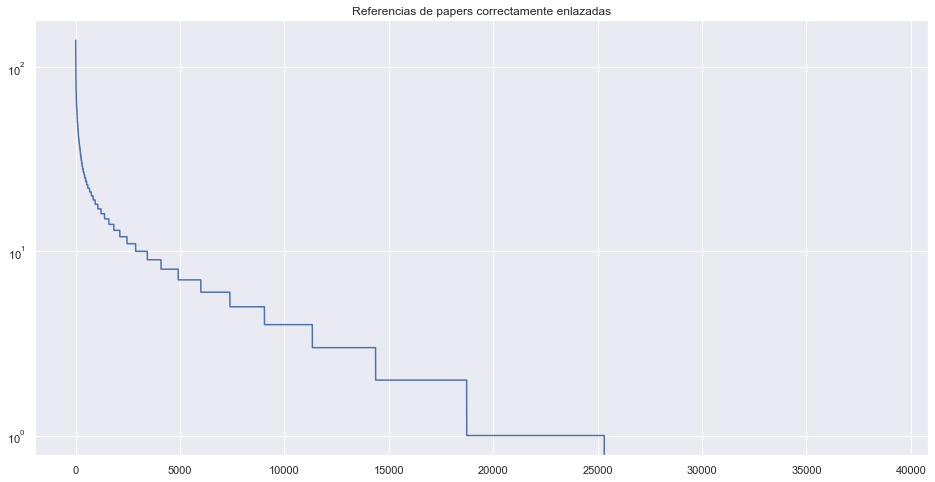

In [ ]:
num_references = sorted([len(paper._references) for paper in papers], reverse=True)
num_referenced_by = sorted([len(paper._referenced_by) for paper in papers], reverse=True)
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(y=num_references, x=range(len(papers)))
ax.set(title="Referencias de papers correctamente enlazadas", yscale="log")
pass

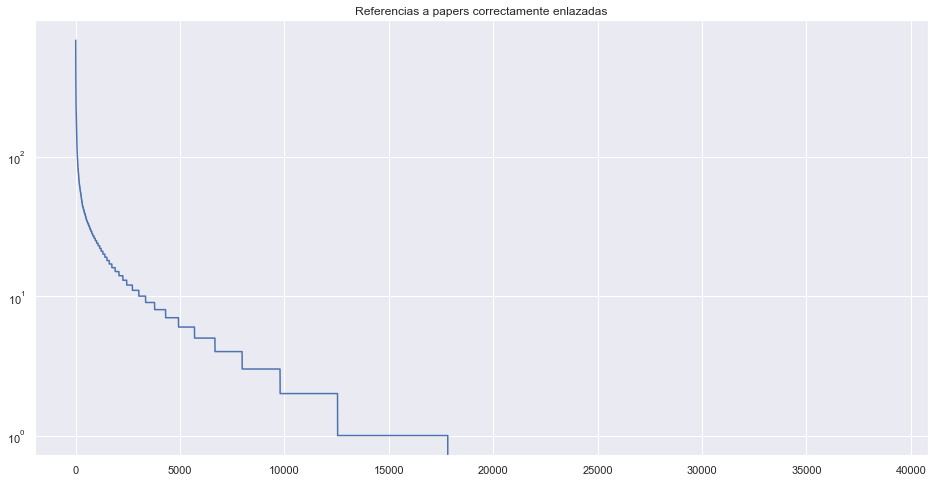

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = sns.lineplot(y=num_referenced_by, x=range(len(papers)))
ax.set(title="Referencias a papers correctamente enlazadas", yscale="log")
pass

Al igual que distintos aspectos de la vida real, se ve como la cantidad de referencias correctamente enlazadas de papers siguen una distribución con cola pesada.

# PageRank

A continuación se realizará el cómputo de los puntajes de PageRank de cada paper.

In [ ]:
# Ref.: https://networkx.github.io/documentation/stable/index.html
!pip install networkx

You are using pip version 19.0.3, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import networkx as nx

def build_graph(papers):
    G = nx.DiGraph()

    # First add the nodes
    for paper in papers:
        G.add_node(paper)
    
    # Then, add the links
    for paper in papers:
        for referenced_paper in paper._references:
            G.add_edge(paper, referenced_paper)
    
    return G

In [ ]:
G = build_graph(papers)
G

In [ ]:
G.number_of_nodes(), G.number_of_edges()

In [ ]:
pr = nx.pagerank(G)
pr

{<__main__.PMCPaper at 0x7f1f2ccfddd0>: 6.295147559139481e-05,
 <__main__.PMCPaper at 0x7f1f2ccfd790>: 1.0560282581349281e-05,
 <__main__.PMCPaper at 0x7f1f2c7e6b90>: 1.0560282581349281e-05,
 <__main__.PMCPaper at 0x7f1f2c782290>: 0.00017682451411246526,
 <__main__.PMCPaper at 0x7f1f2c782790>: 6.152591242219615e-05,
 <__main__.PMCPaper at 0x7f1f2c782250>: 0.00012740165918470543,
 <__main__.PMCPaper at 0x7f1f2c738550>: 8.115604781258472e-05,
 <__main__.PMCPaper at 0x7f1f2ccfd490>: 0.0007489682662681983,
 <__main__.PMCPaper at 0x7f1f2ccfde10>: 1.0560282581349281e-05,
 <__main__.PMCPaper at 0x7f1f2c7206d0>: 3.335207691248526e-05,
 <__main__.PMCPaper at 0x7f1f2ccfdb90>: 1.0560282581349281e-05,
 <__main__.PMCPaper at 0x7f1f2c66fd10>: 1.9491184406055178e-05,
 <__main__.PMCPaper at 0x7f1f2c674a50>: 1.935580330463314e-05,
 <__main__.PMCPaper at 0x7f1f2c6a5c90>: 4.7298185423551025e-05,
 <__main__.PMCPaper at 0x7f1f2c5c2a10>: 1.6272963942197987e-05,
 <__main__.PMCPaper at 0x7f1f2c5de590>: 1.0560

In [ ]:
sorted_pr = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True)}
sorted_pr

{<__main__.PDFPaper at 0x7f1d20b165d0>: 0.01430039297450863,
 <__main__.PDFPaper at 0x7f1d4e97b650>: 0.006843458528155105,
 <__main__.PMCPaper at 0x7f1e6e71b6d0>: 0.004866234092719767,
 <__main__.PDFPaper at 0x7f1d7fb41f50>: 0.004775174613208849,
 <__main__.PMCPaper at 0x7f1e316053d0>: 0.00475030023872773,
 <__main__.PMCPaper at 0x7f1e7cdfc2d0>: 0.004457157589108286,
 <__main__.PDFPaper at 0x7f1d1f5cf890>: 0.0044072907443844,
 <__main__.PMCPaper at 0x7f1e6dd8cf50>: 0.004233732165218011,
 <__main__.PDFPaper at 0x7f1d83065710>: 0.003923803811602406,
 <__main__.PDFPaper at 0x7f1d21966250>: 0.0037811442078439805,
 <__main__.PDFPaper at 0x7f1d9dbb6a10>: 0.0036584608150057128,
 <__main__.PDFPaper at 0x7f1d75c383d0>: 0.0034915974841629935,
 <__main__.PDFPaper at 0x7f1d6e26fe90>: 0.003391606502514324,
 <__main__.PMCPaper at 0x7f1e651a2490>: 0.0029271613198010357,
 <__main__.PDFPaper at 0x7f1d329c9650>: 0.002651556917500903,
 <__main__.PDFPaper at 0x7f1dae89fad0>: 0.002460381954514867,
 <__main

In [ ]:
display_paper(list(sorted_pr.keys())[:5])

Title: Coronavirus as a possible cause of severe acute respiratory syndrome
Authors: Peiris, JSM; Lai, ST; Poon, LLM; Guan, Y; Yam, LYC; Lim, W; Nicholls, J; Yee, WKS; Yan, WW; Cheung, MT; Cheng, VCC; Chan, KH; Tsang, DNC; Yung, RWH; Ng, TK; Yuen, KY
Publish time: 2003-04-19
Linked references: 4
Linked referenced by: 685
Abstract: Summary Background An outbreak of severe acute respiratory syndrome (SARS) has been reported in Hong Kong. We investigated the viral cause and clinical presentation among 50 patients. Methods We analysed case notes and microbiological findings for 50 patients with SARS, representing more than five separate epidemiologically linked transmission clusters. We defined the clinical presentation and risk factors associated with severe disease and investigated the causal agents by chest radiography and laboratory testing of nasopharyngeal aspirates and sera samples. We compared the laboratory findings with those submitted for microbiological investigation of other d

Aquí se puede observar que los papers con mayor PageRank son muy citados y en general son trabajos de décadas pasadas que probablemente constituyen la base de la investigación actual contra el COVID-19.

A continuación se mostrará la distribución de los puntajes de PageRank.

In [ ]:
import numpy as np

pr_values = np.array(list(sorted_pr.values()))

# Remover outliers
pr_mean = np.mean(pr_values)
pr_std = np.std(pr_values)
pr_distance = abs(pr_values - pr_mean)
max_std = 1.5
pr_not_outlier = pr_distance < max_std * pr_std
pr_no_outliers = pr_values[pr_not_outlier]

len(pr_values), len(pr_no_outliers), len(pr_values) - len(pr_no_outliers)

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = sns.distplot(pr_values, kde=False, rug=True)
ax.set(title="Distribución del PageRank de papers de CORD-19 (con outliers)", yscale="log")
pass

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = sns.distplot(pr_no_outliers, kde=False, rug=True)
ax.set(title="Distribución del PageRank de papers de CORD-19 (sin outliers)", yscale="log")
pass

In [ ]:
import pickle
import sys

with open("./pageranks.pkl", "wb") as dump_file:
    pickle.dump(sorted_pr, dump_file)

In [ ]:
papers

 ...]